In [2]:
from tkinter import ttk #8.5で採用された現代的なテーマ
import tkinter as tk
from tkinter import messagebox #メッセージボックスを出す
from tkinter import filedialog
import subprocess, configparser, time
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import (FigureCanvasTkAgg, NavigationToolbar2Tk)
from PIL import ImageTk
import csv, re, xlrd, openpyxl, sys, random, os
import numpy as np
import pandas as pd
from scipy.sparse import csc_matrix
from scipy.sparse import spdiags
import scipy.sparse.linalg as spla
from scipy.signal import find_peaks
import glob, tqdm


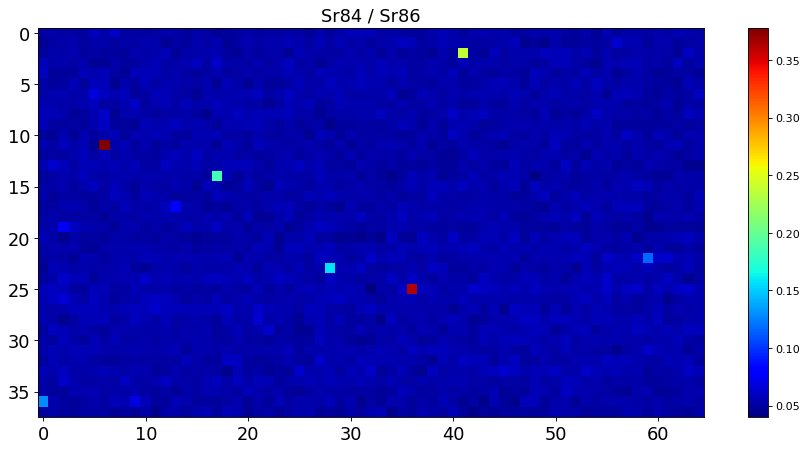

In [3]:
root = tk.Tk()
myfont=("MSゴシック", "10")
class Edit:
    def __init__(self,root):
        self.root = root
        self.frame = tk.Frame(root)
        self.frame.pack(side = tk.TOP)
        self.fileTypes=[
            ("テキストファイル",'*.txt'),
            ("すべてのファイル",'*.*')
        ]
        self.directory = "."
        
        root.title(self.__class__.__name__)#クラスネーム参照
        
        clientHeight = "720"
        clientWidth = "1280"
        cp = configparser.ConfigParser()# ini読み込み準備
        try:
            cp.read(self.__class__.__name__+".ini")
            clientHeight = cp["Client"]["Height"]
            clientWidth = cp["Client"]["Width"]
            self.directory = cp["File"]["Directory"]
        except:
            print(self.__class__.__name__+" :Use default value",file=sys.stderr)

        root.geometry(clientWidth+"x"+clientHeight)
        #root.protocol("WM_DELETE_WINDOW",self.menuFileExit) #右上の×終了でもイベントに飛ばす。
        self.create_menu()

    def create_menu(self):
        menu = tk.Menu(tearoff=0) #インスタンスフォルダ名に使う
        menu_File = tk.Menu(tearoff=0) #インスタンスファイル名に使う
        menu_Help = tk.Menu(tearoff=0)
        
        menu.add_cascade(menu=menu_File, label="ファイル(F)", underline=5,font=myfont)#フォルダ作成。5番目にAlt押すとアンダーラインかつアクセスキー
        menu_File.add_command(label="開く(O)",underline=3,command = self.menuFileOpen,font=myfont)#ファイル作成
        menu_File.add_command(label="終了(X)",underline=3,command = self.menuFileExit,font=myfont)#終了ファイル作成
        
        menu.add_cascade(menu=menu_Help, label="ヘルプ(H)", underline=4,font=myfont)
        menu_Help.add_command(label="ヘルプ(W)", underline=4, command = self.menuHelpOpen,font=myfont)
        menu_Help.add_separator()
        menu_Help.add_command(label="バージョン確認(V)",underline=8, command = self.menuHelpVersion,font=myfont)
        root["menu"] = menu
    
    def menuFileOpen(self):
        self.directname = filedialog.askopenfilename(initialdir = self.directory, filetypes=[("データファイル", "*.xlsx")])
        if not self.directname: #無きゃ中止
            return
        wb = openpyxl.load_workbook(self.directname)
        ws = wb[wb.sheetnames[0]]
        self.columns = []
        all_data = []
        for row in ws.iter_cols():
            b = np.empty((0, 65))
            a = np.empty(0)
            for i, cell in enumerate(row):
                if i > 0:
                    a = np.append(a, cell.value)
                    if (i) % 65 == 0:
                        a = a.reshape((1,65))
                        b = np.vstack((b,a))
                        a = np.empty(0)
                else:
                    self.columns.append(cell.value)
            all_data.append(b)
        self.xy = all_data[:2]
        all_data = all_data[2:]
        self.columns = self.columns[2:]
        self.fig = plt.figure(figsize=(10, 10), dpi=80)
        plt.rcParams['image.cmap'] = 'jet'
        self.fig.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95)
        self.ax = self.fig.add_subplot(1, 1, 1)
        self.fig_canvas = FigureCanvasTkAgg(self.fig, self.root)
        toolbar = NavigationToolbar2Tk(self.fig_canvas, self.root)
        self.fig_canvas.get_tk_widget().pack(side=tk.RIGHT, fill=tk.BOTH, expand=True)
        
        self.combobox = ttk.Combobox(self.frame, width=8, values = self.columns, state="readonly")
        self.combobox.set(self.columns[0])
        self.combobox.bind('<<ComboboxSelected>>', self.combochange)
        self.combobox.pack(side = tk.LEFT)
        
        label1 = tk.Label(self.frame, text=" / ", font=("MSゴシック", "14"))
        label1.pack(side = tk.LEFT)
        
        self.combobox1 = ttk.Combobox(self.frame, width=8, values = self.columns, state="readonly")
        self.combobox1.set(self.columns[1])
        self.combobox1.bind('<<ComboboxSelected>>', self.combochange)
        self.combobox1.pack(side = tk.LEFT)
        
        self.data = all_data[self.combobox.current()]/all_data[self.combobox1.current()]
                
        tk.Label(self.frame, text=" ", font=("MSゴシック", "14")).pack(side = tk.LEFT)
        
        excel = tk.Button(self.frame, text="Excel保存", command = self.save_excel)
        excel.pack(side = tk.RIGHT)
        
        tk.Label(self.frame, text=" ", font=("MSゴシック", "14")).pack(side = tk.RIGHT)
        
        gazou = tk.Button(self.frame, text="画像保存", command = self.save)
        gazou.pack(side = tk.RIGHT)
        
                
        tk.Label(self.frame, text=" ", font=("MSゴシック", "14")).pack(side = tk.RIGHT)
        
        bunpu = tk.Button(self.frame, text="比率プロット", command = self.sub_window)
        bunpu.pack(side = tk.RIGHT)

        img = self.ax.imshow(self.data)
        self.ax.set_title(self.combobox.get() + ' / ' + self.combobox1.get(),fontsize=16)
        '''
        self.ax.set_xlabel("x軸", size = 16, weight = "light")
        self.ax.set_ylabel("y軸", size = 16, weight = "light")
        '''
        self.ax.tick_params(labelsize=16)
        self.cbar = self.fig.colorbar(img, ax=self.ax, orientation='vertical')
        
        
    def menuHelpOpen(self):
        subprocess.Popen(["start","readme.txt"],shell=True)

    def menuFileExit(self):
        cp = configparser.ConfigParser()
        cp["Client"] = {
            "Height": str(root.winfo_height()),
            "Width": str(root.winfo_width())
        }
        cp["File"] = {"Directory": self.directory}
        with open(self.__class__.__name__+".ini","w") as f:
            cp.write(f)
        root.destroy()
    def menuHelpVersion(self):
        s= self.__class__.__name__
        s+=" Version 0.01(2023/3/02)\n"
        s+="©2023 HIROMI YOKOTA\n"
        s+="with Python "+sys.version
        messagebox.showinfo(self.__class__.__name__, s)
        
    def sub_window(self):
        if hasattr(self, "sub_root"):
            pass
        else:
            self.sub_root = tk.Toplevel()
            self.sub_root.title("分布")
            bunpu = tk.Button(self.sub_root, text="画像保存", command = self.save1)
            bunpu.pack(side = tk.TOP)
            self.graph_frame = tk.Frame(self.sub_root)
            self.graph_frame.pack(side=tk.RIGHT)
            self.fig1, self.ax1 = plt.subplots(1,1,figsize=(9,9),dpi=80)
            self.canvas1 = FigureCanvasTkAgg(self.fig1, self.graph_frame)
            self.canvas1.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)
            self.ax1.plot(all_data[self.combobox1.current()],all_data[self.combobox.current()], "o")
            self.ax1.set_xlabel(self.combobox1.get(), size = 16, weight = "light")
            self.ax1.set_ylabel(self.combobox.get(), size = 16, weight = "light")
            self.canvas1.draw()
            
    def save(self):
        self.fig.savefig("img_"+self.combobox.get() + "_div_" + self.combobox1.get() +".png")            
    def save1(self):
        self.fig1.savefig(self.combobox1.get() + "_v_" + self.combobox.get() +"_plot.png")
        
    def save_excel(self):
        wb = openpyxl.load_workbook(self.directname)
        if len(wb.sheetnames) < 2:
            wb.create_sheet(title="hiritu")
            ws = wb[wb.sheetnames[1]]
            self.xy[0] = self.xy[0].reshape(1,-1)[0]
            self.xy[1] = self.xy[1].reshape(1,-1)[0]
            j=1
            ws.cell(row=1, column=1, value = "x軸")
            ws.cell(row=1, column=2, value = "y軸")            
            for y in self.xy:
                for i, da in enumerate(y):
                    ws.cell(row=i+2, column=j, value = da)
                j+=1

        ws = wb[wb.sheetnames[1]]
        mcols = ws.max_column+1
        ws.cell(row=1, column = mcols, value = self.combobox.get() + "/" + self.combobox1.get())
        for i, da in enumerate(self.data.reshape(1,-1)[0]):
            ws.cell(row=i+2, column = mcols, value = da)       
        wb.save(self.directname)
        
        
    def combochange(self, event):  
        self.ax.cla()
        self.data=all_data[self.combobox.current()] / all_data[self.combobox1.current()]
        img = self.ax.imshow(self.data)
        self.ax.set_title(self.combobox.get() + '_div_' + self.combobox1.get(),fontsize=16)
        '''
        self.ax.set_xlabel("x軸", size = 16, weight = "light")
        self.ax.set_ylabel("y軸", size = 16, weight = "light")
        '''
        if hasattr(self, "sub_root"):
            self.ax1.cla()
            self.ax1.plot(all_data[self.combobox1.current()],all_data[self.combobox.current()], "o", )
            self.ax1.set_xlabel(self.combobox1.get(), size = 16, weight = "light")
            self.ax1.set_ylabel(self.combobox.get(), size = 16, weight = "light")
            self.canvas1.draw()
        self.ax.tick_params(labelsize=16)
        self.cbar.update_normal(img)
        self.fig_canvas.draw()
        
def main():
    Edit(root)
    root.mainloop()

if __name__ == '__main__':
    main()